In [1]:
%load_ext autoreload
%autoreload 2

## 1. Generate similarity graph from hierarchies
- outputs `preprocess/similarty_graph.txt`

In [2]:
from DREAMwalk.generate_similarity_net import save_sim_graph
from preprocess.generate_dis_sim import save_dis_sim

kgfile="preprocess/covid19-kg.csv"
networkf='preprocess/graph.txt'
hierf='preprocess/hierarchy.csv'
simf='preprocess/similarity_graph.txt'
dis_gene_dict='preprocess/dis_gene_dict.txt'
cutoff=0.4

save_sim_graph(networkf=networkf,hierf=hierf,outputf=simf,cutoff=cutoff)
save_dis_sim(kgfile, simf)

Similarity graph saved: preprocess/similarity_graph.txt
Disease-gene dict is being generated...
Jaccard similarities are being calculated...
Similarities are being written...


## 2. Generate node embeddings by teleport-guided randomwalk
- outputs `preprocess/embedding_file.pkl`

In [3]:
from DREAMwalk.generate_embeddings import save_embedding_files

# node type file should be given for application of heterogeneous Skip-gram
nodetypef='preprocess/nodetypes.tsv'
networkf='preprocess/graph.txt'
simf='preprocess/similarity_graph.txt'
embeddingf='preprocess/embedding_file.pkl'

save_embedding_files(netf=networkf,sim_netf=simf, outputf=embeddingf,
                    nodetypef=nodetypef,tp_factor=0.3)

/home/hasanbalci/miniconda3/envs/dreamwalk/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


random seed with 42
Reading network files...
Training edge type transition matrix...
Generating paths...
Generating node embeddings...
Node embeddings saved: preprocess/embedding_file.pkl


### 2.1 Visualize generated embedding space 
- outputs `preprocess/embedding_file.pkl`

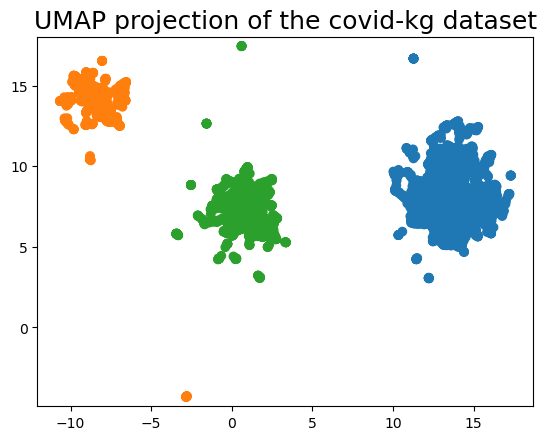

In [13]:
import pickle
import pandas as pd

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import umap

embedding_data = pd.DataFrame()
with open('preprocess/embedding_file.pkl', 'rb') as f:
    data = pickle.load(f)
    embedding_data = pd.DataFrame(data.items(), columns=['col0', 'col1'])

# Expand the array in 'col1' into separate columns
expanded_df = embedding_data['col1'].apply(pd.Series)

# Concatenate the original 'col1' with the expanded columns
result_df = pd.concat([embedding_data['col0'], expanded_df], axis=1)


nodetypes_df = pd.read_csv('preprocess/nodetypes.tsv', sep='\t')
merged_df = pd.merge(result_df, nodetypes_df, left_on='col0', right_on='node', how='left')
# Drop the redundant 'node' column
merged_df = merged_df.drop('node', axis=1)
columns_order = ['col0', 'type'] + [col for col in merged_df.columns if col not in ['col0', 'type']]
merged_df = merged_df[columns_order]

reducer = umap.UMAP()

embedding = reducer.fit_transform(merged_df.iloc[:, 2:])

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in merged_df.type.map({"gene":0, "drug":1, "disease":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the covid-kg dataset', fontsize=18);
#legend = plt.legend(*scatter.legend_elements(),loc="upper right", title="Type")
#plt.add_artist(legend)
plt.show()

## 3. Predict drug-disease association
- saves XGBoost classifiers in `preprocess/model/`

In [1]:
from DREAMwalk.predict_associations import predict_dda

embeddingf='preprocess/embedding_file.pkl'
#pairf='preprocess/dda.tsv'
#modelf='preprocess/clf.pkl'

#predict_dda(embeddingf=embeddingf, pairf=pairf, modelf=modelf)

for i in range(1, 11):
    predict_dda(embeddingf=embeddingf, pairf='preprocess/dda_files/dda' + str(i) + '.tsv', modelf='preprocess/models/clf' + str(i) + '.pkl')

random seed with 42
TRAIN set | Acc: 100.00% | AUROC: 1.0000 | AUPR: 1.0000 | F1-score: 1.0000
VALID set | Acc: 78.79% | AUROC: 0.8834 | AUPR: 0.9027 | F1-score: 0.7910
TEST  set | Acc: 81.82% | AUROC: 0.8809 | AUPR: 0.8527 | F1-score: 0.8261
saved XGBoost classifier: preprocess/models/clf1.pkl
random seed with 42
TRAIN set | Acc: 100.00% | AUROC: 1.0000 | AUPR: 1.0000 | F1-score: 1.0000
VALID set | Acc: 85.61% | AUROC: 0.9178 | AUPR: 0.9295 | F1-score: 0.8527
TEST  set | Acc: 88.64% | AUROC: 0.9405 | AUPR: 0.9401 | F1-score: 0.8889
saved XGBoost classifier: preprocess/models/clf2.pkl
random seed with 42
TRAIN set | Acc: 100.00% | AUROC: 1.0000 | AUPR: 1.0000 | F1-score: 1.0000
VALID set | Acc: 84.09% | AUROC: 0.9125 | AUPR: 0.9241 | F1-score: 0.8421
TEST  set | Acc: 84.85% | AUROC: 0.9112 | AUPR: 0.9101 | F1-score: 0.8485
saved XGBoost classifier: preprocess/models/clf3.pkl
random seed with 42
TRAIN set | Acc: 100.00% | AUROC: 1.0000 | AUPR: 1.0000 | F1-score: 1.0000
VALID set | Acc: 

- calculate drug scores by using XGBoost classifiers

In [2]:
from DREAMwalk.calculate_drug_scores import find_candidates

find_candidates('preprocess/covid19-kg.csv', 'preprocess/embedding_file.pkl', 'preprocess/models/', 'C0740457', 10)

        drug             name      avg_prob
528  DB00997      Doxorubicin   [0.9601269]
26   DB05260  Gallium nitrate   [0.9024806]
341  DB01268        Sunitinib    [0.900071]
226  DB01136       Carvedilol  [0.88901424]
463  DB08896      Regorafenib  [0.88651836]
24   DB06595      Midostaurin   [0.8660757]
196  DB00631      Clofarabine  [0.84951055]
35   DB06589        Pazopanib   [0.8465086]
506  DB14723    Larotrectinib  [0.83564025]
675  DB00398        Sorafenib  [0.83475286]
